In [ ]:
#Pengaturan Directory
import os
import random
import shutil
from imutils import paths
from shutil import copyfile
import zipfile
import os.path
from pathlib import Path

#Visualisasi
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import load_img


#Model Arsitektur
import tensorflow as tf 
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

#Evaluasi 
from sklearn.metrics import classification_report, confusion_matrix 

#Augmentasi Data
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#Log
import pandas as pd

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# shutil.rmtree('/content/SMIDS')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Dataset

In [ ]:
dataset_zip = '/content/drive/MyDrive/Kuliah/Skripsiku/SMIDS.zip'
zip_ext = zipfile.ZipFile(dataset_zip,'r')
zip_ext.extractall('/content/SMIDS')
zip_ext.close()

In [ ]:
os.listdir('/content/SMIDS')

['Abnormal_Sperm', 'Non_Sperm', 'Normal_Sperm']

In [ ]:
print("Jumlah Data Tiap Kelas")
print('Jumlah gambar Abnormal_Sperm   :', len(os.listdir('/content/SMIDS/Abnormal_Sperm')))
print('Jumlah gambar Non_Sperm        :', len(os.listdir('/content/SMIDS/Non_Sperm')))
print('Jumlah gambar Normal_Sperm     :', len(os.listdir('/content/SMIDS/Normal_Sperm')))

Jumlah Data Tiap Kelas
Jumlah gambar Abnormal_Sperm   : 1005
Jumlah gambar Non_Sperm        : 974
Jumlah gambar Normal_Sperm     : 1021


Preprocess

In [ ]:
root_dir = Path('/content/SMIDS')
!ls "/content/SMIDS"

Abnormal_Sperm	Non_Sperm  Normal_Sperm


In [ ]:
base_dir = ('/content/SMIDS/tmp')
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'testing')

#Create Directory
try:
  os.mkdir(base_dir)
  os.mkdir(train_dir)
  os.mkdir(validation_dir)

  #Folder Data Train
  os.mkdir(os.path.join(train_dir, "Normal_Sperm"))
  os.mkdir(os.path.join(train_dir, "Abnormal_Sperm"))
  os.mkdir(os.path.join(train_dir, "Non_Sperm"))

  #Folder Data Uji
  os.mkdir(os.path.join(validation_dir, "Normal_Sperm"))
  os.mkdir(os.path.join(validation_dir, "Abnormal_Sperm"))
  os.mkdir(os.path.join(validation_dir, "Non_Sperm"))

except OSError:
  print("doesn't create")

#Directory Dataset Utama
Normal_Sperm_SOURCE_DIR    ="/content/SMIDS/Normal_Sperm" 
Abnormal_Sperm_SOURCE_DIR   ="/content/SMIDS/Abnormal_Sperm"
Non_Sperm_SOURCE_DIR   ="/content/SMIDS/Non_Sperm"

#Directory Data Latih
TRAINING_Normal_Sperm_DIR  ="/content/SMIDS/tmp/training/Normal_Sperm" 
TRAINING_Abnormal_Sperm_DIR ="/content/SMIDS/tmp/training/Abnormal_Sperm"
TRAINING_Non_Sperm_DIR ="/content/SMIDS/tmp/training/Non_Sperm"

#Directory Data Uji
TESTING_Normal_Sperm_DIR  ="/content/SMIDS/tmp/testing/Normal_Sperm" 
TESTING_Abnormal_Sperm_DIR ="/content/SMIDS/tmp/testing/Abnormal_Sperm"
TESTING_Non_Sperm_DIR ="/content/SMIDS/tmp/testing/Non_Sperm"

In [ ]:
list(os.listdir('/content/SMIDS/tmp'))

['training', 'testing']

In [ ]:
#Fungsi Mengubah Ukuran Citra
ukuran_citra = (128, 128)
def resize (directory):
  image_files = list(paths.list_images(directory))
  data_image = []
  for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, ukuran_citra)
    data_image.append(image)

resize(Normal_Sperm_SOURCE_DIR)
resize(Abnormal_Sperm_SOURCE_DIR)
resize(Non_Sperm_SOURCE_DIR)

In [ ]:
#Fungsi Pembagian Data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = os.listdir(SOURCE)
  size = len(files)*float(SPLIT_SIZE)
  random_files = random.sample(files, int(size))
  for rand in random_files:
    if os.path.getsize(os.path.join(SOURCE, rand)) is 0:
      continue
    elif os.path.exists(os.path.join(TRAINING, rand)):
      continue
    else:
      copyfile(os.path.join(SOURCE, rand), os.path.join(TRAINING, rand))
  for rest in files:
    if rest in random_files:
      continue
    elif os.path.exists(os.path.join(TESTING, rest)):
      continue
    else:
      copyfile(os.path.join(SOURCE, rest), os.path.join(TESTING, rest))

In [ ]:
split_size = .8
#splitting Normal
split_data(Normal_Sperm_SOURCE_DIR, TRAINING_Normal_Sperm_DIR, TESTING_Normal_Sperm_DIR, split_size)

#splitting Cracked
split_data(Abnormal_Sperm_SOURCE_DIR, TRAINING_Abnormal_Sperm_DIR, TESTING_Abnormal_Sperm_DIR, split_size)

#splitting Cracked
split_data(Non_Sperm_SOURCE_DIR, TRAINING_Non_Sperm_DIR, TESTING_Non_Sperm_DIR, split_size)

In [ ]:
print('Jumlah Dataset Normal              :', len(os.listdir(Normal_Sperm_SOURCE_DIR)))
print('Jumlah Data Latih Normal_Sperm     :', len(os.listdir(TRAINING_Normal_Sperm_DIR)))
print('Jumlah Data Uji Normal_Sperm       :', len(os.listdir(TESTING_Normal_Sperm_DIR)))
print('')

print('Jumlah Dataset Abnormal_Sperm      :', len(os.listdir(Abnormal_Sperm_SOURCE_DIR)))
print('Jumlah Data Latih Abnormal_Sperm   :', len(os.listdir(TRAINING_Abnormal_Sperm_DIR)))
print('Jumlah Data Uji Abnormal_Sperm     :', len(os.listdir(TESTING_Abnormal_Sperm_DIR)))
print('')

print('Jumlah Dataset Non_Sperm           :', len(os.listdir(Non_Sperm_SOURCE_DIR)))
print('Jumlah Data Latih Non_Sperm        :', len(os.listdir(TRAINING_Non_Sperm_DIR)))
print('Jumlah Data Uji Non_Sperm          :', len(os.listdir(TESTING_Non_Sperm_DIR)))

Jumlah Dataset Normal              : 1021
Jumlah Data Latih Normal_Sperm     : 816
Jumlah Data Uji Normal_Sperm       : 205

Jumlah Dataset Abnormal_Sperm      : 1005
Jumlah Data Latih Abnormal_Sperm   : 804
Jumlah Data Uji Abnormal_Sperm     : 201

Jumlah Dataset Non_Sperm           : 974
Jumlah Data Latih Non_Sperm        : 779
Jumlah Data Uji Non_Sperm          : 195


In [ ]:
# os.mkdir('/content/SMIDS/augment')
# save_to = '/content/SMIDS/augment'
train_datagen = ImageDataGenerator(
 rescale = 1./255,
 rotation_range = 45,
 zoom_range = 0.10,
 width_shift_range = 0.15,
 height_shift_range = 0.15,
 shear_range = 0.05,
 horizontal_flip = True,
 vertical_flip = True,
 fill_mode = "nearest",
)

train_generator = train_datagen.flow_from_directory(
 train_dir,
 batch_size=32,
 class_mode='categorical',
 target_size=(128,128),
 color_mode='rgb',
#  save_to_dir=save_to
 )

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator=validation_datagen.flow_from_directory(
 validation_dir,
 batch_size=32,
 class_mode='categorical',
 target_size=(128,128),
 color_mode='rgb'
 )

Found 2399 images belonging to 3 classes.
Found 601 images belonging to 3 classes.


In [ ]:
baseModel = MobileNet(weights="imagenet", include_top=False, input_shape = (128, 128, 3), pooling='avg')
baseModel.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

In [ ]:
x = baseModel.output
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(3, activation="softmax")(x)
model = Model(baseModel.input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [ ]:
optimizer = Adam(0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model_save_callback=ModelCheckpoint(
 'model_checkpoint.h5',
 save_best_only=True,
 monitor='val_accuracy',
 mode='auto',
 verbose=1
 )
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

callbacks_list = model_save_callback

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs=100,
    verbose=1,
    validation_steps= validation_generator.n // validation_generator.batch_size,
    validation_data=validation_generator,
    callbacks = callbacks_list
    )

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 1.0106 - accuracy: 0.5239
Epoch 1: val_accuracy improved from -inf to 0.53993, saving model to model_checkpoint.h5
74/74 [==============================] - 26s 168ms/step - loss: 1.0106 - accuracy: 0.5239 - val_loss: 0.9504 - val_accuracy: 0.5399
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.6874
Epoch 2: val_accuracy improved from 0.53993 to 0.69097, saving model to model_checkpoint.h5
74/74 [==============================] - 12s 163ms/step - loss: 0.7208 - accuracy: 0.6874 - val_loss: 0.7660 - val_accuracy: 0.6910
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.7431
Epoch 3: val_accuracy improved from 0.69097 to 0.73785, saving model to model_checkpoint.h5
74/74 [==============================] - 12s 156ms/step - loss: 0.6104 - accuracy: 0.7431 - val_loss: 0.6389 - val_accuracy: 0.7378
Epoch 4/100
74/74 [===========================

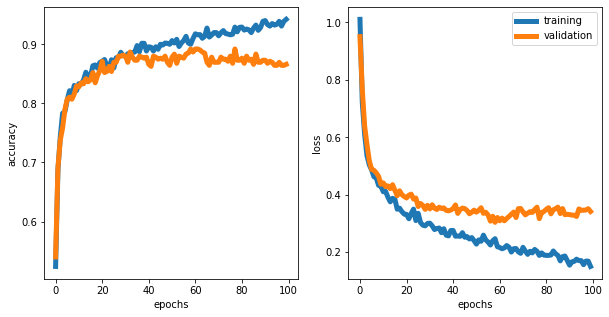

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (10,5))
axs[0].plot(range(len(history.history['accuracy'])), history.history['accuracy'], linewidth = 5, label = "training")
axs[0].plot(range(len(history.history['accuracy'])), history.history['val_accuracy'], linewidth = 5, label = "validation")
axs[1].plot(range(len(history.history['loss'])), history.history['loss'], linewidth = 5, label = "training")
axs[1].plot(range(len(history.history['loss'])), history.history['val_loss'], linewidth = 5, label = "validation")
axs[0].set_xlabel("epochs")
axs[1].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")
axs[1].set_ylabel("loss")
plt.legend()

In [ ]:
loss, acc = model.evaluate(train_generator,steps=len(train_generator),verbose=1)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

val_loss, val_acc = model.evaluate(validation_generator,steps=len(validation_generator),verbose=1)
print('Accuracy on validation data: {:.4f} \nLoss on validation data: {:.4f}'.format(val_acc,val_loss),'\n')

75/75 [==============================] - 10s 127ms/step - loss: 0.1340 - accuracy: 0.9429
Accuracy on training data: 0.9429 
Loss on training data: 0.1340 

19/19 [==============================] - 1s 37ms/step - loss: 0.3412 - accuracy: 0.8686
Accuracy on validation data: 0.8686 
Loss on validation data: 0.3412 



Kelas apa :0
0
[[9.8634712e+01 5.6841690e-02 1.3084521e+00]]


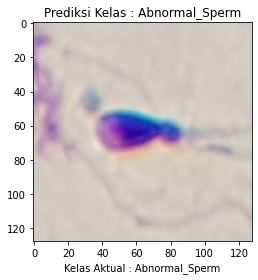

In [ ]:
import requests
from io import BytesIO

from PIL import Image

input_size = (128,128)
input_shape = (128,128, 3)
#define labels
labels = ["Abnormal_Sperm", "Non_Sperm", "Normal_Sperm"]

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

prediction = []
def prepare (filepath):
  input_size = 128
  img_array = cv2.imread(filepath)
  image = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
  new_array = cv2.resize(image,(input_size,input_size))
  img_arr = (np.array(new_array))/255
  return img_arr.reshape(1,input_size,input_size,3)

model = tf.keras.models.load_model("/content/model_checkpoint.h5")
kelas = input ("Kelas apa :")
img_path = "/content/SMIDS/tmp/testing/"+labels[int(kelas)]+"/"
imgs = os.listdir(img_path)
rand_img = os.path.join(img_path, random.choice(imgs))

prediction = model.predict ([prepare(rand_img)])
prediction *= 100
print(np.argmax(prediction))

plt.title ("Prediksi Kelas : {}".format (labels[np.argmax(prediction)]))
plt.xlabel ("Kelas Aktual : " +img_path.split("/")[5])
plt.imshow(np.reshape (prepare(rand_img), (128,128,3)))
plt.tight_layout()
plt.show
print(prediction)

In [ ]:
prediction = []

for classes in labels :
  for count, filename in enumerate (os.listdir(os.path.join(validation_dir,classes))):
    img_path = "/content/SMIDS/tmp/testing/"+classes+"/" + filename
    pred = model.predict([prepare(img_path)])
    prediction.append(np.argmax(pred,axis=1))

print(classification_report(validation_generator.classes,prediction,target_names=labels))

                precision    recall  f1-score   support

Abnormal_Sperm       0.84      0.88      0.86       201
     Non_Sperm       0.95      0.93      0.94       195
  Normal_Sperm       0.91      0.89      0.90       205

      accuracy                           0.90       601
     macro avg       0.90      0.90      0.90       601
  weighted avg       0.90      0.90      0.90       601



In [ ]:
confusion_matrix(validation_generator.classes,prediction)

array([[176,   8,  17],
       [ 13, 181,   1],
       [ 20,   2, 183]])

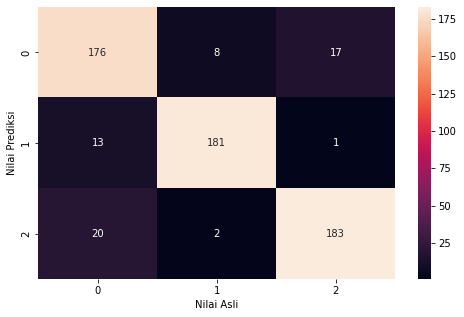

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(validation_generator.classes,prediction), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Nilai Asli")
plt.ylabel("Nilai Prediksi")
plt.show()

In [ ]:
df = pd.DataFrame({'Kelas Prediksi':yp, 'Kelas Asli':np.argmax(pred,axis=1)})

ValueError: ignored

In [ ]:
df.loc[df['Kelas Prediksi']==0].loc[df['Kelas Asli']==0]

,Kelas Prediksi,Kelas Asli


In [ ]:
total = 0
betul = 1
validation_dir = '/content/SMIDS/tmp/testing/'

for classes in labels:
  for count, filename in enumerate (os.listdir((os.path.join(validation_dir,classes)))):
    img_path = '/content/SMIDS/tmp/testing/' + classes + '/' + filename
    prediction = model.predict([prepare(img_path)])
    if labels [np.argmax(prediction)] == classes:
      betul += 1
    total += 1
print ("Akurasi pada Data adalah {} %".format((betul/total)*100))

Akurasi pada Data adalah 90.01663893510815 %


In [ ]:
ypred = model.predict(validation_generator)